> # This is the full implementation of the DFO swarm algorithm for finding the optimal z-dimension in a GAN.



# 1- Dependencies (Required Packages)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision

# 2- Helper Functions

### 2.1- **(inception_score)** This function calculates the Inception Score for a set of images, which is a metric used to evaluate the quality and diversity of generated images.

In [2]:
def inception_score(imgs, model, batch_size=32, splits=10, device='cuda'):
    """
    Calculates the Inception Score for a set of images.

    Args:
        imgs (torch.Tensor): A tensor of images (N, C, H, W).
        model (nn.Module): A pre-trained classifier model (e.g., Inception).
        batch_size (int): Batch size for processing images.
        splits (int): Number of splits for calculating the score.
        device (str): Device to run computations ('cuda' or 'cpu').

    Returns:
        tuple: Mean and standard deviation of the Inception Score.
    """
    model.eval()
    preds = []

    for i in range(0, imgs.shape[0], batch_size):
        batch = imgs[i:i + batch_size].float().to(device)
        # Resize images to 28x28 if necessary
        batch = F.interpolate(batch, size=(28, 28), mode='bilinear', align_corners=False)
        # Ensure batch has shape [batch_size, channels, height, width]
        with torch.no_grad():
            pred = F.softmax(model(batch), dim=1)
            
        preds.append(pred.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        py = np.mean(part, axis=0)
        kl = part * (np.log(part) - np.log(py))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

### 2.2- **(show_images)** This function, show_images, is used to display a grid of images in a matplotlib plot.

In [3]:
def show_images(images, num_images=10, cols=10):
    # Convert images from PyTorch tensor to numpy and prepare for display
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert from PyTorch tensor to numpy
    rows = -(-num_images // cols)  # Compute number of rows (ceiling division)
    
    # Create the subplot grid
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 3))
    axs = axs.flatten()  # Flatten the axes array for easier indexing
    
    for i in range(rows * cols):
        if i < num_images:
            img = (images[i] + 1) / 2  # Denormalize image to [0, 1] range
            axs[i].imshow(np.squeeze(img), cmap='gray')
            axs[i].axis('off')
        else:
            axs[i].axis('off')  # Hide unused axes

    plt.tight_layout()
    plt.show()


### 2.3- **(test_accuracy)**  this function is used to compute accuracy

In [4]:
def test_accuracy(model_classifier, test_loader):
    model_classifier.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_classifier(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

### 2.4- **(set_seed)**  This function, set_seed, is used to set the random seed for reproducibility in a PyTorch and NumPy environment.

In [5]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

### 2.5- Data augmentation and normalization for classifier only

In [6]:

transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Changed for grayscale
])

# Train and Test datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders for train and test
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 460kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.25MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.43MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# 3- Classifier for evaluate the z dimension 
This code defines and trains a Convolutional Neural Network (CNN) for classifying MNIST handwritten digits, using PyTorch. The model, MNISTClassifier, consists of two convolutional layers, dropout for regularization, and fully connected layers, trained with the Adam optimizer and a learning rate scheduler.

In [7]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Changed for grayscale
])

# Train and Test datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders for train and test
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)

# Initialize the model, loss function, and optimizer
model_classifier = MNISTClassifier().to(device)
optimizer = optim.Adam(model_classifier.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# Train for more epochs with learning rate scheduler
for epoch in range(5):  # Increased epochs
    model_classifier.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_classifier(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}")

# Function to compute accuracy
def test_accuracy(model_classifier, test_loader):
    model_classifier.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_classifier(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Evaluate accuracy on the test dataset
accuracy = test_accuracy(model_classifier, test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch 1: Loss = 0.1552
Epoch 2: Loss = 0.0267
Epoch 3: Loss = 0.0325
Epoch 4: Loss = 0.0451
Epoch 5: Loss = 0.0065
Test Accuracy: 98.98%


# 4-  Data preprocessing for GAN 

In [13]:
transformforGAN = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = torchvision.datasets.MNIST(root="dataset/", train=True, transform=transformforGAN, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 454kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.24MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.89MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# 5-  Architecture of  GAN Model 

## Hyperparameters
- **Learning Rate**: 2e-4  
- **Batch Size**: 128  
- **Image Size**: 64x64  
- **Noise Dimension (z_dim)**: Tuned using DFO  
- **Epochs**: 20  
- **Device**: Uses GPU if available  

## Generator Model
- Takes a random noise vector (`z_dim`) and **upsamples** it through transposed convolutions.
- Uses **Batch Normalization** and **ReLU activations** for stable training.
- Outputs a **grayscale image** (MNIST dataset) with `Tanh()` activation.

## Discriminator Model
- A **CNN-based classifier** that distinguishes real vs. fake images.
- Uses **LeakyReLU** and **BatchNorm** for better gradient flow.
- Outputs a **sigmoid probability** for classification.

## Weight Initialization
- Convolutional layers are initialized with **normal distribution** (mean=0, std=0.02) to stabilize training.

In [18]:
# Hyperparameters
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1  # Changed to 1 for MNIST (grayscale)
# NOISE_DIM = 100
NUM_EPOCHS = 20
FEATURES_DISC = 64
FEATURES_GEN = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, channels_img, features_gen):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.net = nn.Sequential(
            self._block(noise_dim, features_gen * 8, 4, 1, 0),
            self._block(features_gen * 8, features_gen * 4, 4, 2, 1),
            self._block(features_gen * 4, features_gen * 2, 4, 2, 1),
            self._block(features_gen * 2, features_gen, 4, 2, 1),
            nn.ConvTranspose2d(features_gen, channels_img, 4, 2, 1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.net(x)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_disc):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, features_disc, 4, 2, 1),
            nn.LeakyReLU(0.2),
            self._block(features_disc, features_disc * 2, 4, 2, 1),
            self._block(features_disc * 2, features_disc * 4, 4, 2, 1),
            self._block(features_disc * 4, features_disc * 8, 4, 2, 1),
            nn.Conv2d(features_disc * 8, 1, 4, 2, 0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

# 6- Fitness Function for GAN Optimization

This function evaluates the effectiveness of different **z-dimensions** in generating realistic images using a **GAN**.  

### **Key Steps:**
1. **Dataset Subsampling:**  
   - Uses 5% of the dataset to reduce computational cost.  
   - Loads a mini-batch using a DataLoader.  

2. **Model Initialization:**  
   - Defines a **Generator** and **Discriminator** using the given `z_dim` and image channels.  
   - Uses **Binary Cross-Entropy Loss (BCELoss)** for training.  
   - Optimized using **Adam optimizer**.  

3. **GAN Training:**  
   - Trains the Discriminator to distinguish real and fake images.  
   - Trains the Generator to improve image quality based on Discriminator feedback.  

4. **Performance Evaluation:**  
   - Generates images using fixed noise.  
   - Computes **Inception Score (IS)** to measure diversity and realism.  
   - Displays sample generated images.  

5. **Returns:**  
   - The inverse **Inception Score (1/IS)** as the fitness value, where a lower score indicates better performance.  


In [14]:
def fitness_function(z_dim, dataset, device, CHANNELS_IMG, FEATURES_GEN, FEATURES_DISC, BATCH_SIZE):

    subset_size = int(0.05 * len(dataset)) 
    indices = np.random.choice(len(dataset), size=subset_size, replace=False)
    subset = torch.utils.data.Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize models
    gen = Generator(z_dim, CHANNELS_IMG, FEATURES_GEN).to(device)
    disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
    
    # Loss and optimizers
    criterion = nn.BCELoss()
    opt_gen = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
    

    fixed_noise = torch.randn(32, z_dim, 1, 1).to(DEVICE)
    
    gen.train()
    disc.train()
    
    for epoch in range(NUM_EPOCHS):
        # print(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        for batch_idx, (real, _) in enumerate(dataloader):
            real = real.to(DEVICE)
            batch_size = real.shape[0]
    
            # Train Discriminator
            noise = torch.randn(batch_size, z_dim, 1, 1).to(DEVICE)
            fake = gen(noise)
            
            disc_real = disc(real).reshape(-1)
            disc_fake = disc(fake.detach()).reshape(-1)
            
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            
            disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()
    
            # Train Generator
            output = disc(fake).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()
    
    SEED = 42
    set_seed(SEED)

    # Example parameters
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    NOISE_DIM = z_dim

    # Generate fixed noise for the generator
    fixed_noise = torch.randn(1000, NOISE_DIM).to(device).view(1000, NOISE_DIM, 1, 1)

    with torch.no_grad():
        fake_images = gen(fixed_noise)  # Generate images using the generator

        # Assume 'model' is your pre-trained classifier (e.g., Inception model)
        is_mean, is_std = inception_score(fake_images, model_classifier, device=device)

        print(f"Inception Score: {1/is_mean} ± {is_std}, z_dim {z_dim}")

    with torch.no_grad():
        fake = gen(fixed_noise)
        show_images(fake, num_images=10, cols=5)
        plt.close()
    
    return (1/is_mean)


# 6- Dispersive Flies Optimisation (DFO) for z-Dimension Selection

This function optimizes the **z-dimension** (`z_dim`) for a **GAN** using **Differential Fly Optimization (DFO)**. It iteratively improves the population of candidate `z_dim` values to find the best-performing one.

### **Key Steps:**
1. **Initialization:**  
   - Defines population size and bounds (`min_z_dim`, `max_z_dim`).  
   - Initializes **GAN parameters** like `CHANNELS_IMG`, `FEATURES_GEN`, and `BATCH_SIZE`.  

2. **Optimization Loop:**  
   - Evaluates the **fitness** of each candidate `z_dim` using `fitness_function()`.  
   - Selects the **best** `z_dim` based on the lowest fitness score.  
   - Updates population using **elite strategy** and **neighborhood selection**:  
     - **Exploitation:** Moves towards the best candidate.  
     - **Exploration:** Occasionally selects a random `z_dim` to avoid local optima.  

3. **Output:**  
   - Returns a dictionary with tested `z_dim` values and their fitness scores.  
   - Outputs the best `z_dim` found.  

In [16]:
def dfo(dataset, device, min_z_dim, max_z_dim, population_size=2, max_iterations=5):
    """
    
    Args:
    dataset (torch.utils.data.Dataset): Input dataset
    device (torch.device): Device to run the computation
    min_z_dim (int): Minimum z dimension
    max_z_dim (int): Maximum z dimension
    population_size (int): Number of candidate solutions
    max_iterations (int): Maximum number of iterations
    
    Returns:
    dict: Results including best z_dim and performance metrics
    """
    # Hyperparameters
    CHANNELS_IMG = 1
    FEATURES_GEN = 64
    FEATURES_DISC = 64
    BATCH_SIZE = 128
    DELTA = 0.001
    
    # Initialize population of z_dim values
    population = np.random.randint(min_z_dim, max_z_dim + 1, size=population_size)
    
    # Results tracking
    results = {
        'z_dims': [],
        'fitness_scores': [],
        # 'execution_times': []
    }
    # DFO main loop
    for iteration in range(max_iterations):
        print(population)
        print(f"DFO Iteration {iteration + 1}/{max_iterations}")
        
        # Evaluate fitness for each z_dim
        fitness_values = []
        
        for z_dim in population:
            fitness = fitness_function(
                z_dim, 
                dataset, 
                device, 
                CHANNELS_IMG, 
                FEATURES_GEN, 
                FEATURES_DISC, 
                BATCH_SIZE
            )
            fitness_values.append(fitness)
            results['z_dims'].append(z_dim)
            results['fitness_scores'].append(fitness)
        
        # results['execution_times'].append(end_time - start_time)
        
        # Find the best z_dim
        best_idx = np.argmin(fitness_values)
        best_z_dim = population[best_idx]
        best_fitness = fitness_values[best_idx]
        
        print(f"Best z_dim: {best_z_dim}, Fitness: {best_fitness}")
        
        # DFO update process (elite strategy)
        for i in range(population_size):
            if i == best_idx:
                continue  # Keep the best solution


            # print("before DFO")
            # print(population[i])
            # Choose neighbors
            left = (i-1) % population_size
            right = (i+1) % population_size
            best_neighbor = right if fitness_values[right] < fitness_values[left] else left
            
            # Update population
            if np.random.rand() < DELTA:
                population[i] = np.random.randint(min_z_dim, max_z_dim + 1)  # Random exploration
            else:
                u = np.random.uniform(0.05, 0.1)
                # u = np.random.rand()
                population[i] = int(population[best_neighbor] + (u * (population[best_idx] - population[i])))
                
                population[i] = max(min_z_dim, min(population[i], max_z_dim))  # Bound check
            # print("after DFO")
            print(population[i])
    return results, population[best_idx]


# 7- Set the Parameters and Run the Code

[426 108]
DFO Iteration 1/1
Inception Score: 0.1986011988695799 ± 0.26772505044937134, z_dim 426


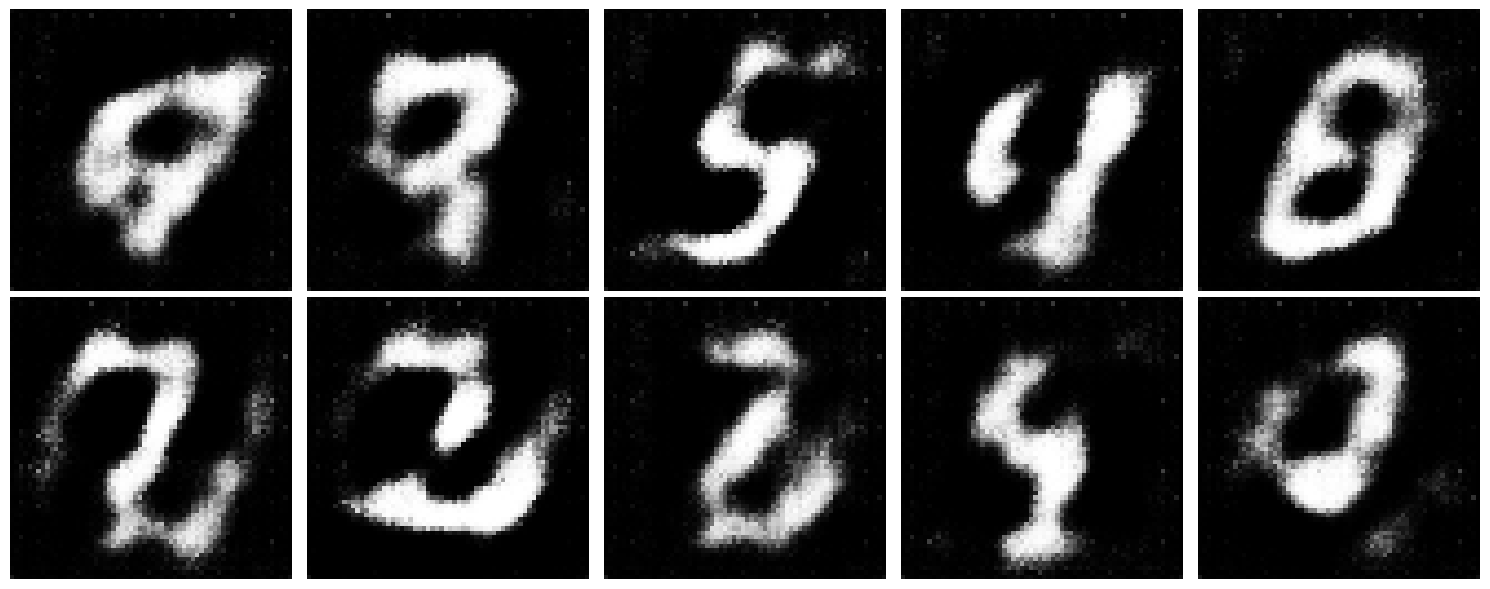

Inception Score: 0.15946982900476747 ± 0.38805586099624634, z_dim 108


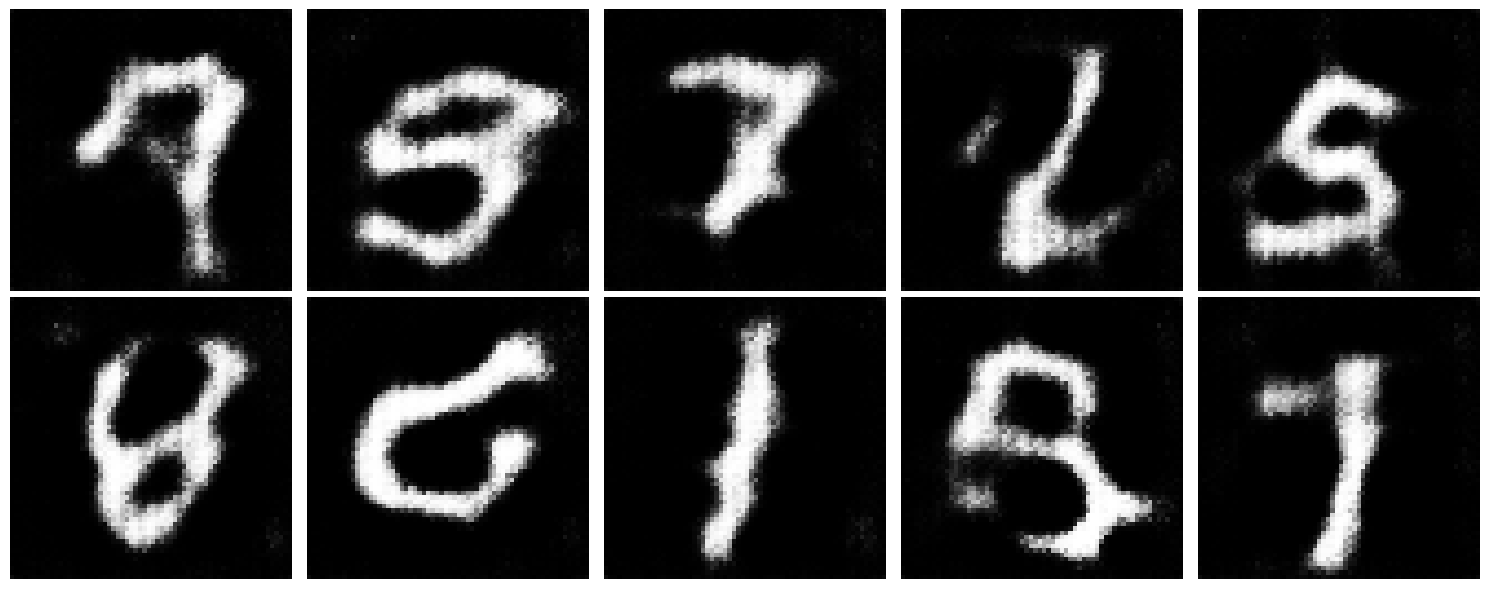

Best z_dim: 108, Fitness: 0.15946982900476747
76
[0.1986011988695799, 0.15946982900476747]

Optimal Z-Dimension Found:
Best Z-Dim: 108
Best Fitness Score: 0.15946982900476747


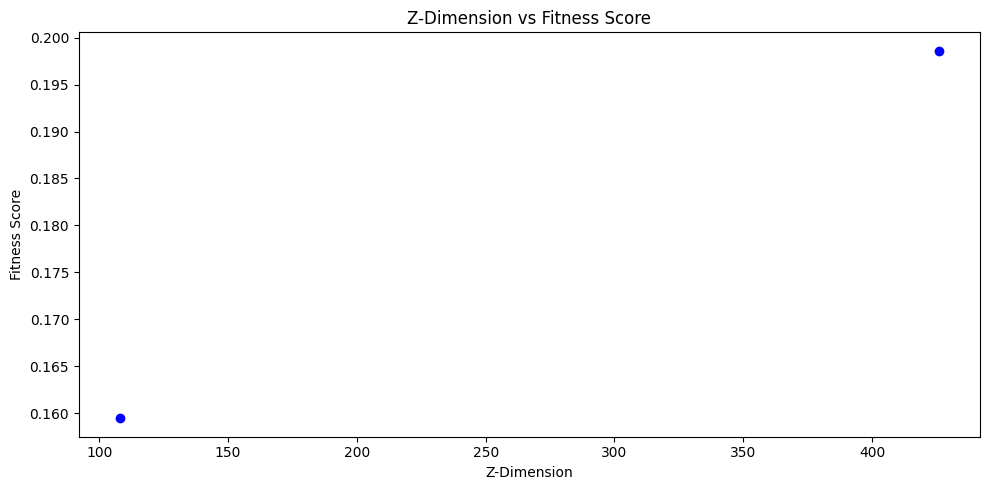

In [19]:
# DFO Parameters
MIN_Z_DIM = 5
MAX_Z_DIM = 500
POPULATION_SIZE = 2
MAX_ITERATIONS = 1

# Run DFO to find optimal z_dim
results, weights = dfo(
    dataset, 
    device, 
    MIN_Z_DIM, 
    MAX_Z_DIM, 
    population_size=POPULATION_SIZE, 
    max_iterations=MAX_ITERATIONS
)

# Find the best z_dim
best_z_dim_index = np.argmin(results['fitness_scores'])
print(results['fitness_scores'])
best_z_dim = results['z_dims'][best_z_dim_index]

best_fitness = results['fitness_scores'][best_z_dim_index]

print(f"\nOptimal Z-Dimension Found:")
print(f"Best Z-Dim: {best_z_dim}")
print(f"Best Fitness Score: {best_fitness}")

<ipython-input-20-515945a4b04f>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # You can also try 'ggplot', 'seaborn-whitegrid', etc.


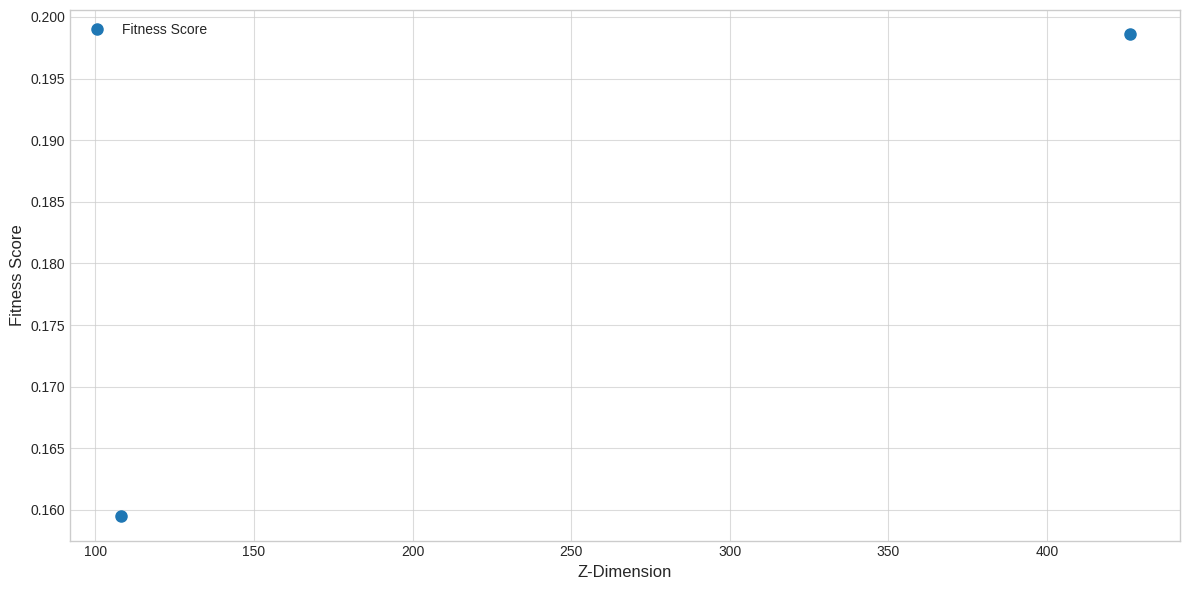

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Enable a valid modern style
plt.style.use('seaborn-whitegrid')  

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(results['z_dims'], results['fitness_scores'], 'o', 
         linewidth=2, markersize=8, label='Fitness Score')

# Add gridlines for better readability
plt.grid(visible=True, which='major',  alpha=0.7)

# Add labels and a title
plt.xlabel('Z-Dimension', fontsize=12)
plt.ylabel('Fitness Score', fontsize=12)
# plt.title('Relationship Between Z-Dimension and Fitness Score', fontsize=14, fontweight='bold')

# Add a legend
plt.legend(loc='best', fontsize=10)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-25-f7c4cee3b133>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # You can try other styles like 'ggplot' or 'seaborn-darkgrid'


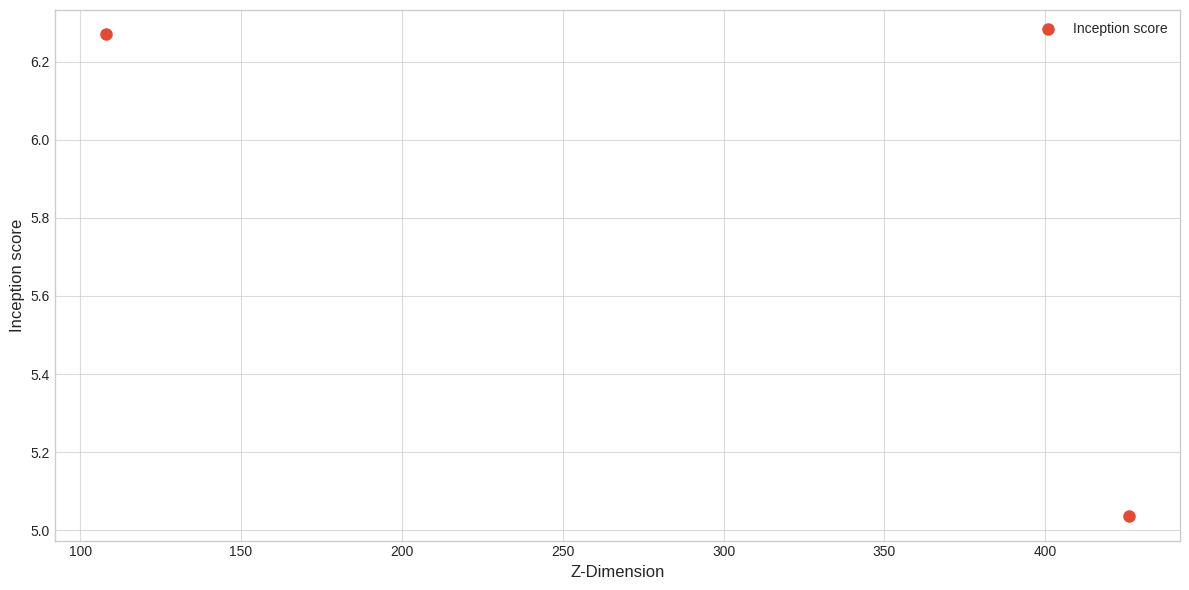

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Compute reciprocal of fitness scores
y = [1 / score for score in results['fitness_scores']]
x = results['z_dims']

# Enable a modern style
plt.style.use('seaborn-whitegrid')  # You can try other styles like 'ggplot' or 'seaborn-darkgrid'

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, 'o', linewidth=2, markersize=8, label='Inception score')

# Add gridlines for better readability
plt.grid(visible=True, which='major', alpha=0.7)

# Add labels and a title
plt.xlabel('Z-Dimension', fontsize=12)
plt.ylabel('Inception score', fontsize=12)
# plt.title('Relationship Between Z-Dimension and 1/Fitness Score', fontsize=14, fontweight='bold')

# Add a legend
plt.legend(loc='best', fontsize=10)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-22-21bedaf5ce5e>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # You can try other styles like 'ggplot'


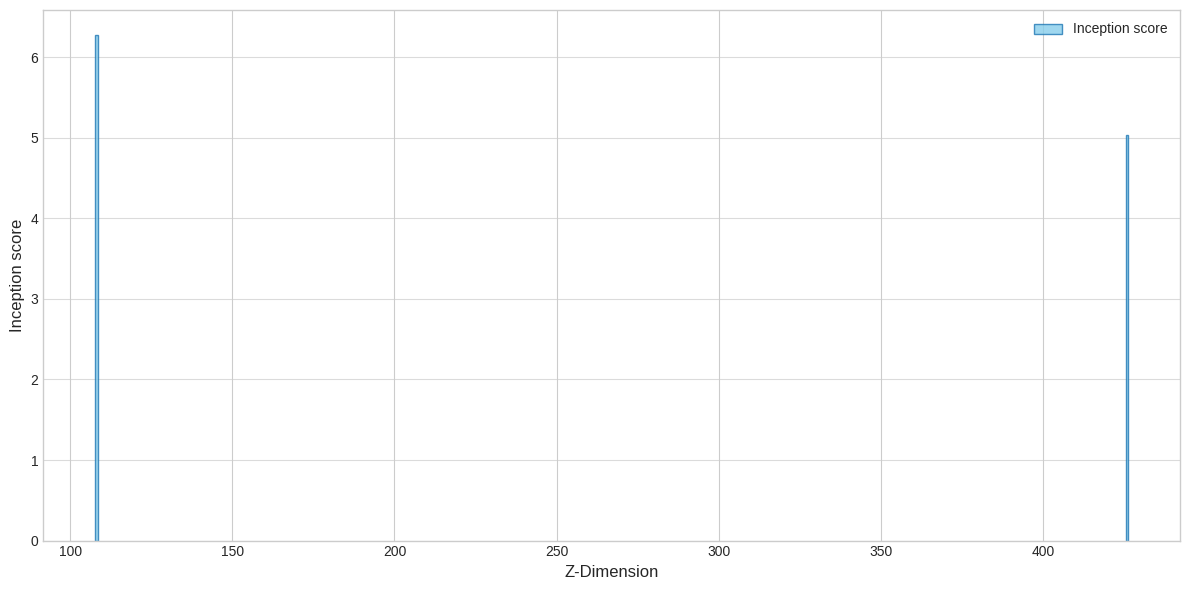

In [22]:
import matplotlib.pyplot as plt
import numpy as np



# Compute reciprocal of fitness scores
y = [1 / score for score in results['fitness_scores']]
x = results['z_dims']

# Enable a modern style
plt.style.use('seaborn-whitegrid')  # You can try other styles like 'ggplot'

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x, y, color='skyblue', edgecolor='#1f77b4', alpha=0.8, label='Inception score')

# Add gridlines for better readability
plt.grid(visible=True, which='major', axis='y', alpha=0.7)

# Add labels and a title
plt.xlabel('Z-Dimension', fontsize=12)
plt.ylabel('Inception score', fontsize=12)
# plt.title('Relationship Between Z-Dimension and 1/Fitness Score', fontsize=14, fontweight='bold')

# Add a legend
plt.legend(loc='best', fontsize=10)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()
